# Super resolución de imágenes usando redes convolucionales
**Autores**

* Oleg Sovero
* Jose Huertas
* Gustavo Rojas
* Alfredo Tarazona

In [21]:
# Fuentes de información:
# https://keras.io/examples/vision/super_resolution_sub_pixel/
# https://blog.paperspace.com/image-super-resolution/

In [22]:
# Importamos las librerias
import os
import math
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

from IPython.display import display


In [23]:
# Montar en el directorio de drive, asi no gastamos mucha ram
from google.colab import drive
drive.mount('/content/drive')
working_dir = "/content/drive/MyDrive/Dataset/SIR_backup"
%cd $working_dir

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1HWgELbfAzgbCmGvQOJLuIEqQ7rDlmM_v/Dataset/SIR_backup


In [24]:
%ls $working_dir

Test_Set/  Training_Set/  Validation_Set/


In [25]:
train_path = working_dir + '/Training_Set'
valid_path = working_dir + '/Validation_Set'

In [26]:
# Mis cambios
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    train_path,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    valid_path,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)


Found 64 files belonging to 1 classes.
Using 52 files for training.
Found 31 files belonging to 1 classes.
Using 6 files for validation.


Escalamos las imagenes

In [27]:
# Escalamos las imágenes para que el valor de cada píxel este en el rango de 0 y 1
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)


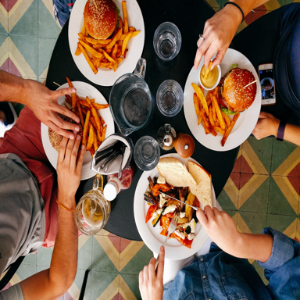

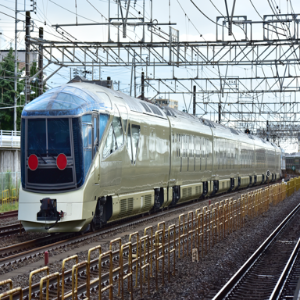

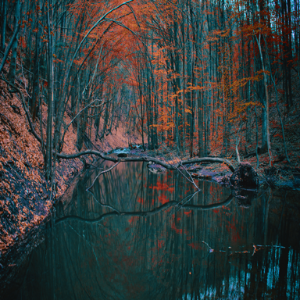

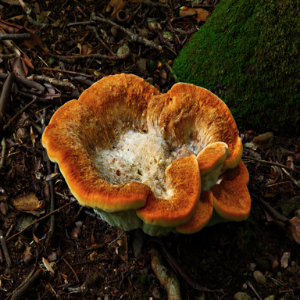

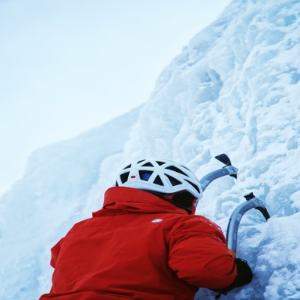

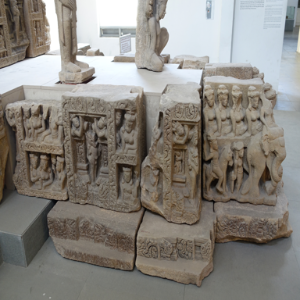

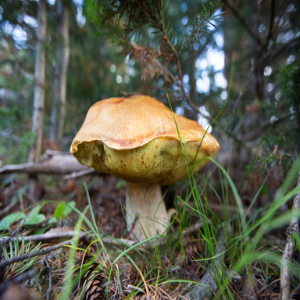

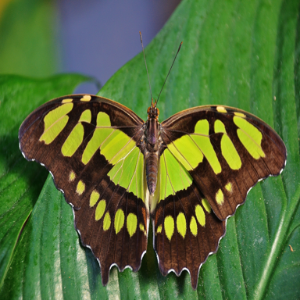

In [29]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))


Creamos el conjunto de testeo

In [30]:
# def process_input(img, target_size, upscale_factor):
#     return tf.image.resize(img, [target_size, target_size], method="area")


# def process_target(img):
#     img = tf.image.rgb_to_yuv(img) # Cambiamos el formato de la imagen a una escala  yuv
#     return tf.split(img, 3, axis=3)[0]


# train_data_yuv = train_data.map(process_target)
# train_data_scaled = train_data_yuv.map(lambda img: (process_input(img, input_size, upscale_factor), img))

# train_ds = train_data_scaled.prefetch(buffer_size=32) #

# validate_data_yuv = validate_data.map(process_target)
# validate_data_scaled = validate_data_yuv.map(lambda img: (process_input(img, input_size, upscale_factor), img))

# valid_ds = validate_data_scaled.prefetch(buffer_size=32) #

# EL SIGUIENTE CODIGO NO PODEMOS HACERLO PORQUE NO TENEMOS CONJUNTO DE TEST
# dataset = os.path.join(root_dir, "images")
# test_path = os.path.join(dataset, "test")
test_path = working_dir + '/Test_Set'
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)


In [31]:
# Preprocesamos las imagenes
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)


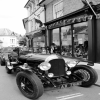

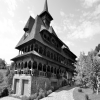

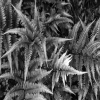

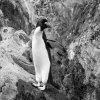

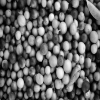

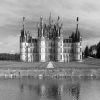

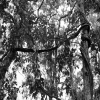

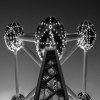

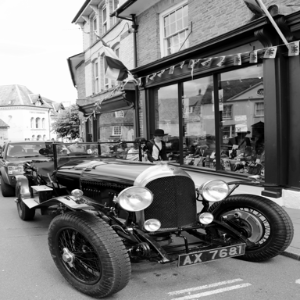

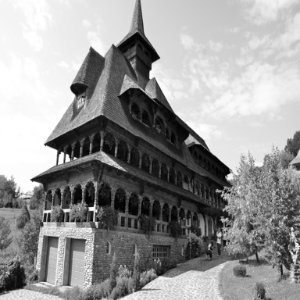

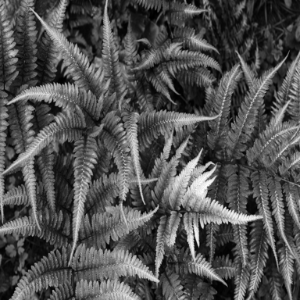

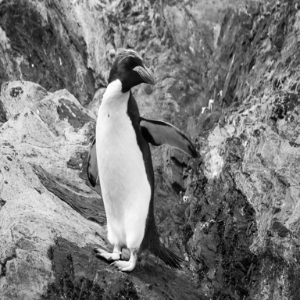

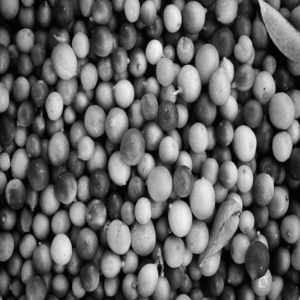

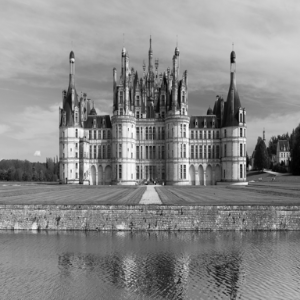

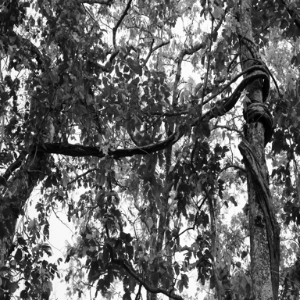

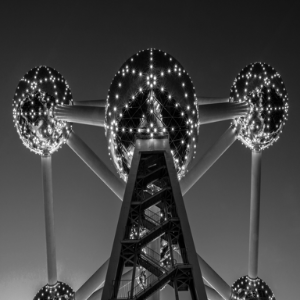

In [32]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))


In [33]:
# l = list(train_ds)

# # Mostramos una imagen con baja y con alta resolución de nuestro conjunto de datos
# img1 = tf.keras.preprocessing.image.array_to_img(l[0][1][0])
# plt.imshow(img1)
# plt.figure(figsize=(img1.size[0], img1.size[1]))
# plt.show()
# print(img1.size,"\n")

# img2 = tf.keras.preprocessing.image.array_to_img(l[0][0][0])
# plt.imshow(img2)
# plt.figure(figsize=(img2.size[0], img2.size[1]))
# plt.show()
# print(img2.size)

Construimos el modelo

In [34]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(256, 7, **conv_args)(inputs)
    x = layers.Conv2D(128, 7, **conv_args)(x)
    x = layers.Conv2D(128, 7, **conv_args)(x)
    x = layers.Conv2D(64, 7, **conv_args)(x)
    x = layers.Conv2D(64, 5, **conv_args)(x)
    x = layers.Conv2D(32, 5, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)
# probar luego con esta arquitectura

# inputs = keras.Input(shape=(None, None, 1))
# conv1 = layers.Conv2D(64, 5, activation="tanh", padding="same")(inputs)
# conv2 = layers.Conv2D(32, 3, activation="tanh", padding="same")(conv1)
# conv3 = layers.Conv2D((upscale_factor*upscale_factor), 3, activation="sigmoid", padding="same")(conv2)
# outputs = tf.nn.depth_to_space(conv3, upscale_factor, data_format='NHWC')


Definimos funciones de utilidad

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Especificar los limites.
    x1, x2, y1, y2 = 200, 300, 100, 200
    #x1, x2, y1, y2 = 50, 100, 50, 100
    # Aplicar the x-limits.
    axins.set_xlim(x1, x2)
    # Aplicar the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Dibujar la línea.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restaurar la imagen.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [36]:
# Usamos ESPCN como un callback para imprimir las métricas en cada época.
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Almacenar valor PSNR en cada epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))



In [37]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=20)

checkpoint_filepath = working_dir + "/Temp"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 256)   12800     
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 128)   1605760   
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 128)   802944    
                                                                 
 conv2d_12 (Conv2D)          (None, None, None, 64)    401472    
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 64)    102464    
                                                                 
 conv2d_14 (Conv2D)          (None, None, None, 32)    5123

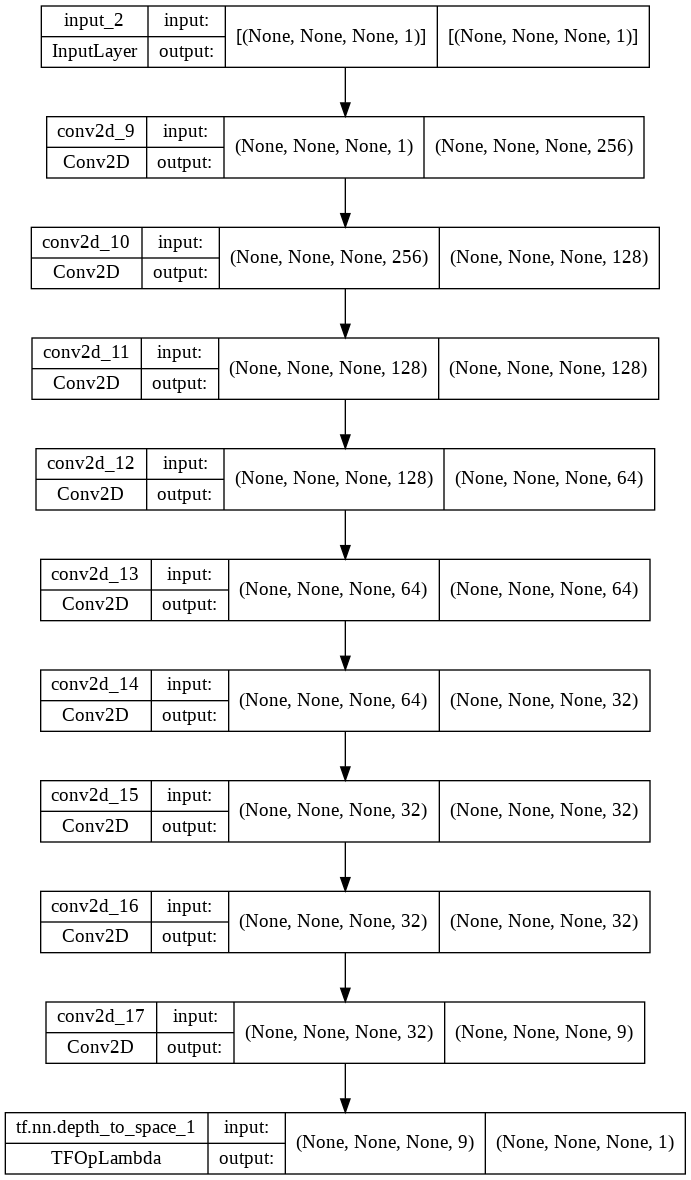

In [38]:
# Graficamos el modelo
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Entrenamos el modelo

Epoch 1/500
Mean PSNR for epoch: 20.00


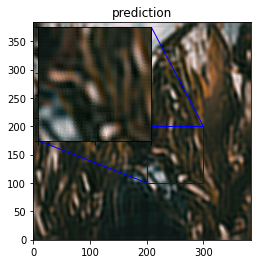

7/7 - 3s - loss: 0.0064 - val_loss: 0.0100 - 3s/epoch - 456ms/step
Epoch 2/500
Mean PSNR for epoch: 20.18
7/7 - 2s - loss: 0.0063 - val_loss: 0.0096 - 2s/epoch - 277ms/step
Epoch 3/500
Mean PSNR for epoch: 20.33
7/7 - 2s - loss: 0.0060 - val_loss: 0.0093 - 2s/epoch - 275ms/step
Epoch 4/500
Mean PSNR for epoch: 20.42
7/7 - 2s - loss: 0.0059 - val_loss: 0.0091 - 2s/epoch - 298ms/step
Epoch 5/500
Mean PSNR for epoch: 20.49
7/7 - 2s - loss: 0.0059 - val_loss: 0.0089 - 2s/epoch - 301ms/step
Epoch 6/500
Mean PSNR for epoch: 20.55
7/7 - 3s - loss: 0.0057 - val_loss: 0.0088 - 3s/epoch - 361ms/step
Epoch 7/500
Mean PSNR for epoch: 20.40
7/7 - 2s - loss: 0.0057 - val_loss: 0.0091 - 2s/epoch - 301ms/step
Epoch 8/500
Mean PSNR for epoch: 20.49
7/7 - 2s - loss: 0.0059 - val_loss: 0.0089 - 2s/epoch - 276ms/step
Epoch 9/500
Mean PSNR for epoch: 20.52
7/7 - 2s - loss: 0.0057 - val_loss: 0.0089 - 2s/epoch - 282ms/step
Epoch 10/500
Mean PSNR for epoch: 20.64
7/7 - 2s - loss: 0.0056 - val_loss: 0.0086 - 

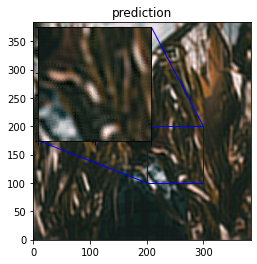

7/7 - 3s - loss: 0.0062 - val_loss: 0.0078 - 3s/epoch - 398ms/step
Epoch 22/500
Mean PSNR for epoch: 20.11
7/7 - 2s - loss: 0.0056 - val_loss: 0.0097 - 2s/epoch - 294ms/step
Epoch 23/500
Mean PSNR for epoch: 21.12
7/7 - 2s - loss: 0.0056 - val_loss: 0.0077 - 2s/epoch - 280ms/step
Epoch 24/500
Mean PSNR for epoch: 20.58
7/7 - 2s - loss: 0.0055 - val_loss: 0.0088 - 2s/epoch - 279ms/step
Epoch 25/500
Mean PSNR for epoch: 21.14
7/7 - 2s - loss: 0.0054 - val_loss: 0.0077 - 2s/epoch - 281ms/step
Epoch 26/500
Mean PSNR for epoch: 21.15
7/7 - 2s - loss: 0.0051 - val_loss: 0.0077 - 2s/epoch - 281ms/step
Epoch 27/500
Mean PSNR for epoch: 21.42
7/7 - 2s - loss: 0.0048 - val_loss: 0.0072 - 2s/epoch - 304ms/step
Epoch 28/500
Mean PSNR for epoch: 21.43
7/7 - 2s - loss: 0.0047 - val_loss: 0.0072 - 2s/epoch - 312ms/step
Epoch 29/500
Mean PSNR for epoch: 21.51
7/7 - 2s - loss: 0.0046 - val_loss: 0.0071 - 2s/epoch - 301ms/step
Epoch 30/500
Mean PSNR for epoch: 21.57
7/7 - 2s - loss: 0.0046 - val_loss: 0

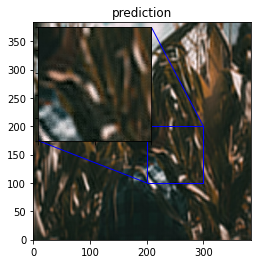

7/7 - 3s - loss: 0.0042 - val_loss: 0.0065 - 3s/epoch - 395ms/step
Epoch 42/500
Mean PSNR for epoch: 21.93
7/7 - 2s - loss: 0.0042 - val_loss: 0.0064 - 2s/epoch - 309ms/step
Epoch 43/500
Mean PSNR for epoch: 21.96
7/7 - 2s - loss: 0.0042 - val_loss: 0.0064 - 2s/epoch - 340ms/step
Epoch 44/500
Mean PSNR for epoch: 21.46
7/7 - 2s - loss: 0.0042 - val_loss: 0.0071 - 2s/epoch - 323ms/step
Epoch 45/500
Mean PSNR for epoch: 21.92
7/7 - 2s - loss: 0.0045 - val_loss: 0.0064 - 2s/epoch - 279ms/step
Epoch 46/500
Mean PSNR for epoch: 21.97
7/7 - 2s - loss: 0.0042 - val_loss: 0.0064 - 2s/epoch - 278ms/step
Epoch 47/500
Mean PSNR for epoch: 20.60
7/7 - 2s - loss: 0.0043 - val_loss: 0.0087 - 2s/epoch - 280ms/step
Epoch 48/500
Mean PSNR for epoch: 21.05
7/7 - 2s - loss: 0.0050 - val_loss: 0.0079 - 2s/epoch - 277ms/step
Epoch 49/500
Mean PSNR for epoch: 21.49
7/7 - 2s - loss: 0.0049 - val_loss: 0.0071 - 2s/epoch - 280ms/step
Epoch 50/500
Mean PSNR for epoch: 21.84
7/7 - 2s - loss: 0.0044 - val_loss: 0

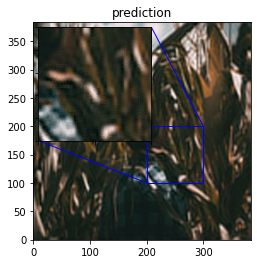

7/7 - 3s - loss: 0.0039 - val_loss: 0.0058 - 3s/epoch - 368ms/step
Epoch 62/500
Mean PSNR for epoch: 22.37
7/7 - 2s - loss: 0.0038 - val_loss: 0.0058 - 2s/epoch - 310ms/step
Epoch 63/500
Mean PSNR for epoch: 22.40
7/7 - 2s - loss: 0.0038 - val_loss: 0.0058 - 2s/epoch - 300ms/step
Epoch 64/500
Mean PSNR for epoch: 22.42
7/7 - 2s - loss: 0.0038 - val_loss: 0.0057 - 2s/epoch - 303ms/step
Epoch 65/500
Mean PSNR for epoch: 22.45
7/7 - 2s - loss: 0.0037 - val_loss: 0.0057 - 2s/epoch - 300ms/step
Epoch 66/500
Mean PSNR for epoch: 22.47
7/7 - 2s - loss: 0.0037 - val_loss: 0.0057 - 2s/epoch - 300ms/step
Epoch 67/500
Mean PSNR for epoch: 22.23
7/7 - 2s - loss: 0.0038 - val_loss: 0.0060 - 2s/epoch - 283ms/step
Epoch 68/500
Mean PSNR for epoch: 22.37
7/7 - 2s - loss: 0.0038 - val_loss: 0.0058 - 2s/epoch - 280ms/step
Epoch 69/500
Mean PSNR for epoch: 22.31
7/7 - 2s - loss: 0.0041 - val_loss: 0.0059 - 2s/epoch - 281ms/step
Epoch 70/500
Mean PSNR for epoch: 22.03
7/7 - 2s - loss: 0.0047 - val_loss: 0

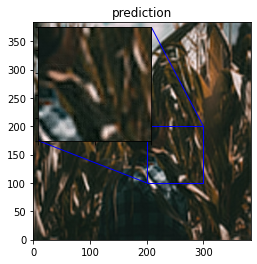

7/7 - 3s - loss: 0.0046 - val_loss: 0.0059 - 3s/epoch - 418ms/step
Epoch 82/500
Mean PSNR for epoch: 22.22
7/7 - 2s - loss: 0.0042 - val_loss: 0.0060 - 2s/epoch - 293ms/step
Epoch 83/500
Mean PSNR for epoch: 22.34
7/7 - 2s - loss: 0.0038 - val_loss: 0.0058 - 2s/epoch - 279ms/step
Epoch 84/500
Mean PSNR for epoch: 22.62
7/7 - 2s - loss: 0.0037 - val_loss: 0.0055 - 2s/epoch - 306ms/step
Epoch 85/500
Mean PSNR for epoch: 22.57
7/7 - 2s - loss: 0.0036 - val_loss: 0.0055 - 2s/epoch - 300ms/step
Epoch 86/500
Mean PSNR for epoch: 22.51
7/7 - 2s - loss: 0.0037 - val_loss: 0.0056 - 2s/epoch - 281ms/step
Epoch 87/500
Mean PSNR for epoch: 22.34
7/7 - 2s - loss: 0.0037 - val_loss: 0.0058 - 2s/epoch - 278ms/step
Epoch 88/500
Mean PSNR for epoch: 22.50
7/7 - 2s - loss: 0.0038 - val_loss: 0.0056 - 2s/epoch - 280ms/step
Epoch 89/500
Mean PSNR for epoch: 22.48
7/7 - 2s - loss: 0.0037 - val_loss: 0.0056 - 2s/epoch - 281ms/step
Epoch 90/500
Mean PSNR for epoch: 22.44
7/7 - 2s - loss: 0.0036 - val_loss: 0

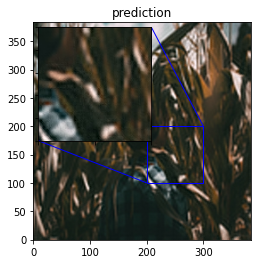

7/7 - 3s - loss: 0.0034 - val_loss: 0.0052 - 3s/epoch - 394ms/step
Epoch 102/500
Mean PSNR for epoch: 22.85
7/7 - 2s - loss: 0.0034 - val_loss: 0.0052 - 2s/epoch - 315ms/step
Epoch 103/500
Mean PSNR for epoch: 22.87
7/7 - 2s - loss: 0.0034 - val_loss: 0.0052 - 2s/epoch - 280ms/step
Epoch 104/500
Mean PSNR for epoch: 22.88
7/7 - 2s - loss: 0.0034 - val_loss: 0.0051 - 2s/epoch - 303ms/step
Epoch 105/500
Mean PSNR for epoch: 22.81
7/7 - 2s - loss: 0.0034 - val_loss: 0.0052 - 2s/epoch - 300ms/step
Epoch 106/500
Mean PSNR for epoch: 22.59
7/7 - 2s - loss: 0.0035 - val_loss: 0.0055 - 2s/epoch - 283ms/step
Epoch 107/500
Mean PSNR for epoch: 22.68
7/7 - 2s - loss: 0.0038 - val_loss: 0.0054 - 2s/epoch - 278ms/step
Epoch 108/500
Mean PSNR for epoch: 22.18
7/7 - 2s - loss: 0.0038 - val_loss: 0.0061 - 2s/epoch - 279ms/step
Epoch 109/500
Mean PSNR for epoch: 21.25
7/7 - 2s - loss: 0.0041 - val_loss: 0.0075 - 2s/epoch - 279ms/step
Epoch 110/500
Mean PSNR for epoch: 22.82
7/7 - 2s - loss: 0.0045 - va

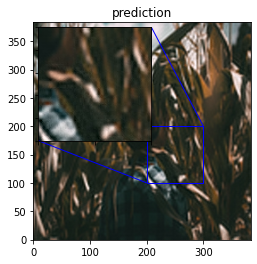

7/7 - 3s - loss: 0.0034 - val_loss: 0.0053 - 3s/epoch - 371ms/step
Epoch 122/500
Mean PSNR for epoch: 22.89
7/7 - 2s - loss: 0.0034 - val_loss: 0.0051 - 2s/epoch - 279ms/step
Epoch 123/500
Mean PSNR for epoch: 22.84
7/7 - 2s - loss: 0.0034 - val_loss: 0.0052 - 2s/epoch - 280ms/step
Epoch 124/500
Mean PSNR for epoch: 21.98
7/7 - 2s - loss: 0.0040 - val_loss: 0.0063 - 2s/epoch - 278ms/step
Epoch 125/500
Mean PSNR for epoch: 22.59
7/7 - 2s - loss: 0.0045 - val_loss: 0.0055 - 2s/epoch - 279ms/step
Epoch 126/500
Mean PSNR for epoch: 22.84
7/7 - 2s - loss: 0.0040 - val_loss: 0.0052 - 2s/epoch - 280ms/step
Epoch 127/500
Mean PSNR for epoch: 22.93
7/7 - 2s - loss: 0.0037 - val_loss: 0.0051 - 2s/epoch - 280ms/step
Epoch 128/500
Mean PSNR for epoch: 22.95
7/7 - 2s - loss: 0.0034 - val_loss: 0.0051 - 2s/epoch - 280ms/step
Epoch 129/500
Mean PSNR for epoch: 22.92
7/7 - 2s - loss: 0.0033 - val_loss: 0.0051 - 2s/epoch - 304ms/step
Epoch 130/500
Mean PSNR for epoch: 23.00
7/7 - 2s - loss: 0.0033 - va

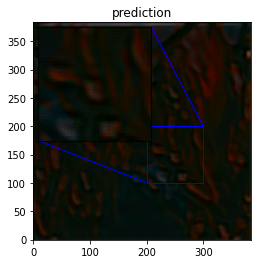

7/7 - 3s - loss: 0.0582 - val_loss: 0.2031 - 3s/epoch - 373ms/step
Epoch 142/500
Mean PSNR for epoch: 6.91
7/7 - 2s - loss: 0.9960 - val_loss: 0.2035 - 2s/epoch - 280ms/step
Epoch 143/500
Mean PSNR for epoch: 9.02
7/7 - 2s - loss: 0.1609 - val_loss: 0.1252 - 2s/epoch - 279ms/step
Epoch 144/500
Mean PSNR for epoch: 12.57
7/7 - 2s - loss: 0.1881 - val_loss: 0.0554 - 2s/epoch - 280ms/step
Epoch 145/500
Mean PSNR for epoch: 10.84
7/7 - 2s - loss: 0.0695 - val_loss: 0.0824 - 2s/epoch - 274ms/step
Epoch 146/500
Mean PSNR for epoch: 11.32
7/7 - 2s - loss: 0.0791 - val_loss: 0.0738 - 2s/epoch - 273ms/step
Epoch 147/500
Mean PSNR for epoch: 12.40
7/7 - 2s - loss: 0.0704 - val_loss: 0.0575 - 2s/epoch - 275ms/step
Epoch 148/500
Mean PSNR for epoch: 12.61
7/7 - 2s - loss: 0.0701 - val_loss: 0.0548 - 2s/epoch - 277ms/step
Epoch 149/500
Mean PSNR for epoch: 12.32
7/7 - 2s - loss: 0.0683 - val_loss: 0.0586 - 2s/epoch - 276ms/step
Epoch 150/500
Mean PSNR for epoch: 12.15
7/7 - 2s - loss: 0.0677 - val_

In [40]:
epochs = 500

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# Mejores pesos se guardan en el modelo.
model.load_weights(checkpoint_filepath)


Resultados del modelo entrenado

PSNR of low resolution image and high resolution image is 25.0704
PSNR of predict and high resolution is 25.1871


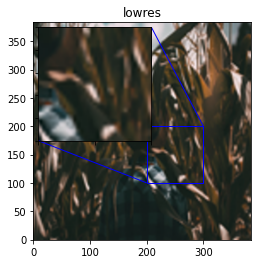

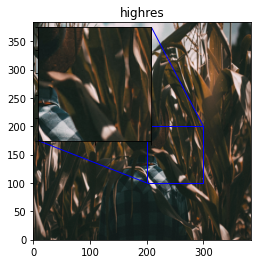

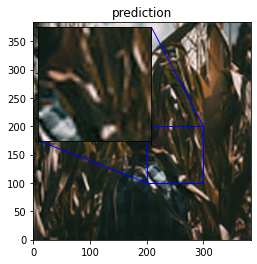

PSNR of low resolution image and high resolution image is 26.4479
PSNR of predict and high resolution is 26.3400


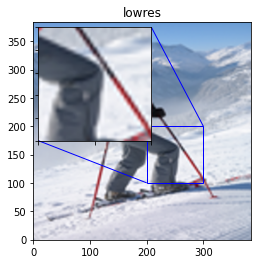

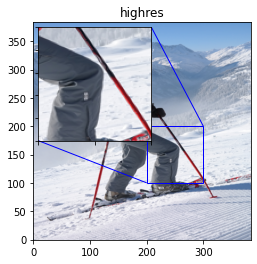

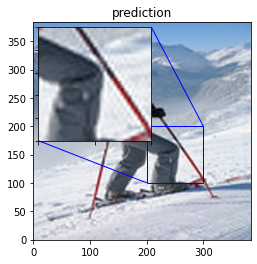

PSNR of low resolution image and high resolution image is 21.9050
PSNR of predict and high resolution is 21.9116


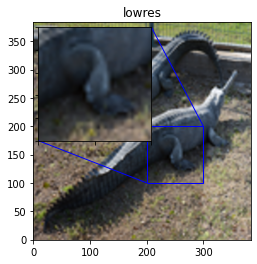

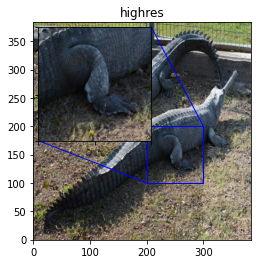

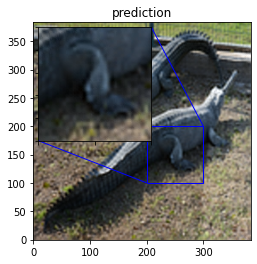

PSNR of low resolution image and high resolution image is 26.0968
PSNR of predict and high resolution is 25.9443


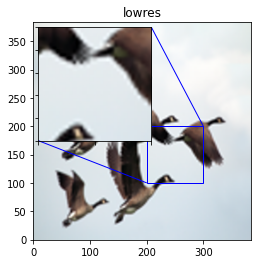

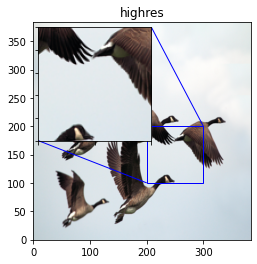

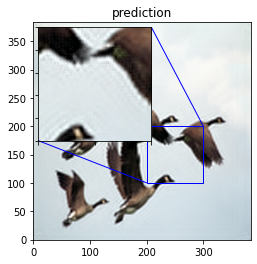

PSNR of low resolution image and high resolution image is 18.0269
PSNR of predict and high resolution is 18.4436


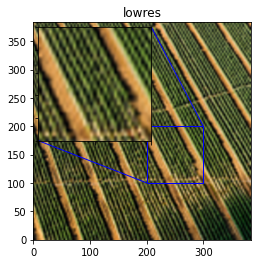

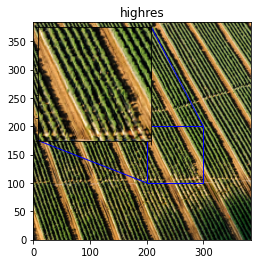

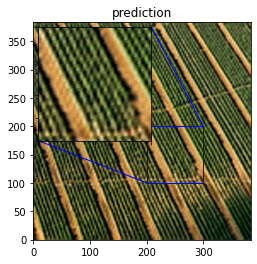

PSNR of low resolution image and high resolution image is 27.4206
PSNR of predict and high resolution is 27.3325


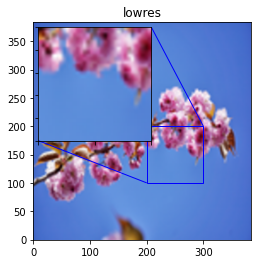

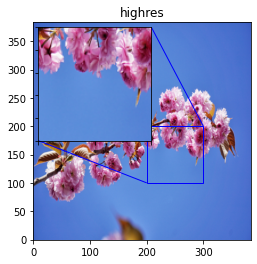

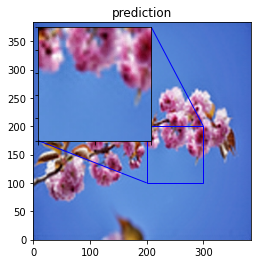

PSNR of low resolution image and high resolution image is 22.5449
PSNR of predict and high resolution is 22.5502


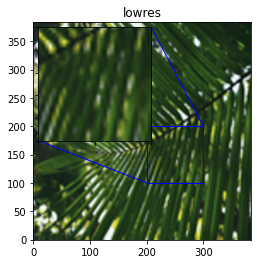

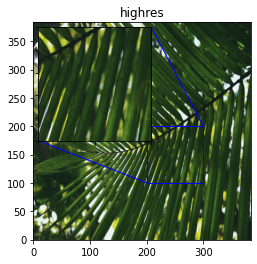

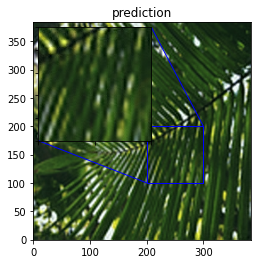

PSNR of low resolution image and high resolution image is 22.6204
PSNR of predict and high resolution is 22.7029


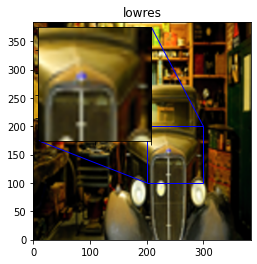

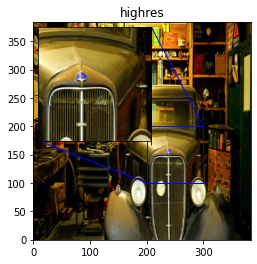

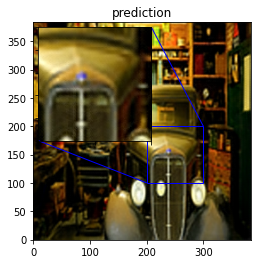

Avg. PSNR of lowres images is 23.7666
Avg. PSNR of reconstructions is 23.8015


In [41]:
# Resultados del modelo entrenado
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
num_images = 0

for index, test_img_path in enumerate(test_img_paths[0:40]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr
    num_images += 1

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / num_images))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / num_images))
